In [3]:
from unicodedata import normalize

import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
import numpy as np
# ignore the warning
import warnings

from tensorflow.python.ops.metrics_impl import precision, accuracy

warnings.filterwarnings('ignore')
Xian_cohort = pd.read_csv('/Users/gengzhi/Desktop/Xian_cohort.csv')
nonXian_cohort = pd.read_csv('/Users/gengzhi/Desktop/nonXian_cohort.csv')
Xian_cohort = pd.concat([Xian_cohort, nonXian_cohort])
imputer = KNNImputer(n_neighbors=2)
# only 69th column have missing value
Xian_cohort['CRP'] = imputer.fit_transform(Xian_cohort)[:, 69]
adata = Xian_cohort[Xian_cohort['surgical_classify'] != 1]
# drop the columns that are not needed,include '生存时间‘，’death(死亡)'
adata = adata.drop(['survival_time', 'death'], axis=1)
adata.index = range(1, len(adata)+1)
X = adata.drop('SSUM400', axis=1)
y = adata['SSUM400']
# EO,CRP fit semi-normal distribution, let calculate the std when u=0
EO = X['EO']
CRP = X['CRP']
EO_std = np.sqrt(np.square(EO).sum() / (len(EO) + 1))
CRP_std = np.sqrt(np.square(CRP).sum() / (len(CRP) + 1))
print(EO_std, CRP_std)
# perform log transformation on some columns,including NEUT,SII,EO,BASO,TT,FDP,D_D,AST,ALT,AST_ALT,GGT_Y,CK,TG,HCY,HbA1c,CRP,GLU
X['NEUT_log10'] = np.log10(X['NEUT'])
X['SII_log10'] = np.log10(X['SII'])
X['BASO_log10'] = np.log10(X['BASO'] + 0.005)
X['TT_log10'] = np.log10(X['TT'])
X['FDP_log10'] = np.log10(X['FDP'])
X['D_D_log10'] = np.log10(X['D_D'])
X['AST_log10'] = np.log10(X['AST'])
X['ALT_log10'] = np.log10(X['ALT'])
X['AST_ALT_log10'] = np.log10(X['AST_ALT'])
X['GGT_Y_log10'] = np.log10(X['GGT_Y'])
X['CK_log10'] = np.log10(X['CK'])
X['TG_log10'] = np.log10(X['TG'])
X['HCY_log10'] = np.log10(X['HCY'])
X['HbA1c_log10'] = np.log10(X['HbA1c'])
X['GLU_log10'] = np.log10(X['GLU'])
for i in ['NEUT', 'SII', 'BASO', 'TT', 'FDP', 'D_D', 'AST', 'ALT', 'AST_ALT', 'GGT_Y', 'CK', 'TG', 'HCY', 'HbA1c',
          'GLU']:
    X.drop(i, axis=1, inplace=True)

0.1748658452351037 19.26822991505532


In [4]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, f1_score,recall_score,accuracy_score
final_auc = []
auc_normal_log = []
index_selected = []
feature_biased = []
f1= []
accuracy_score_r = []
recall = []
accuracy_score_r_log = []
recall_log = []
f1_log = []
check =[]
feature_importance =[]
for i in np.random.randint(0, 10000, 1000):
 X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=i,shuffle=True)
 scaler = StandardScaler()
 features = X.columns
 train_index = X_train.index
 test_index = X_test.index
 X_train = pd.DataFrame(X_train, columns=features)
 X_train1 = scaler.fit_transform(X_train.drop(['EO', 'CRP','reappear', 'surgical_classify', 'sex', 'stroke_if', 'TIA_if', 'hypertension', 'diabete'], axis=1))
 X_train1 = pd.DataFrame(X_train1, columns=features.drop(['EO', 'CRP','reappear', 'surgical_classify', 'sex', 'stroke_if', 'TIA_if', 'hypertension', 'diabete']),index=train_index)
 X_train['EO'] = X_train['EO'] / EO_std
 X_train['CRP'] = X_train['CRP'] / CRP_std
 X_train1['EO'] = X_train['EO'].values
 X_train1['CRP'] = X_train['CRP'].values
 X_train1[['reappear', 'surgical_classify', 'sex', 'stroke_if', 'TIA_if', 'hypertension', 'diabete']] = X_train[['reappear', 'surgical_classify', 'sex', 'stroke_if', 'TIA_if', 'hypertension', 'diabete']].values
 X_train = X_train1
 X_test = pd.DataFrame(X_test, columns=features)
 X_test1 = scaler.transform(X_test.drop(['EO', 'CRP','reappear', 'surgical_classify', 'sex', 'stroke_if', 'TIA_if', 'hypertension', 'diabete'], axis=1))
 X_test1 = pd.DataFrame(X_test1, columns=features.drop(['EO', 'CRP','reappear', 'surgical_classify', 'sex', 'stroke_if', 'TIA_if', 'hypertension', 'diabete']),index=test_index)
 X_test['EO'] = X_test['EO'] / EO_std
 X_test['CRP'] = X_test['CRP'] / CRP_std
 X_test1['EO'] = X_test['EO'].values
 X_test1['CRP'] = X_test['CRP'].values
 X_test1[['reappear', 'surgical_classify', 'sex', 'stroke_if', 'TIA_if', 'hypertension', 'diabete']] = X_test[['reappear', 'surgical_classify', 'sex', 'stroke_if', 'TIA_if', 'hypertension', 'diabete']].values
 X_test = X_test1
 selected_features = pd.read_csv('/Users/gengzhi/Desktop/indeed_features.csv', header=0,index_col=0)
 X_train = X_train[selected_features['0']]
 X_test = X_test[selected_features['0']]
 X_test.index = range(0, len(X_test))
 model = LogisticRegression(max_iter=1000)
 model.fit(X_train, y_train)
 auc_normal_log.append(roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]))
 feature_importance.append(model.coef_)
 a,b,threshold = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
 best_threshold = threshold[np.argmax(b-a)]
 f1_log.append(f1_score(y_test, model.predict_proba(X_test)[:, 1] > best_threshold))
 accuracy_score_r_log.append(accuracy_score(y_test, model.predict_proba(X_test)[:, 1] > best_threshold))
 recall_log.append(recall_score(y_test, model.predict_proba(X_test)[:, 1] > best_threshold))
 y_pred = []
 cor={}
 cor_negative = {}
 cor_row = {}
 cor_row_negative = {}
 cor_row_receptor = {}
 for column in X_test.columns:
         row_df_col = X_test.drop(column,axis=1)
         X_train_col = X_train.drop(column,axis=1)
         cor_matrix = np.corrcoef(row_df_col,X_train_col,rowvar=True)[:len(X_test),len(X_test):]
         cor[column] = pd.DataFrame(cor_matrix,index=[np.linspace(0,len(X_test)-1,len(X_test)).astype(int)],columns=train_index).T
         cor_row_receptor[column] = pd.Series()
         cor_row_negative[column] = pd.Series()
         for j in range(0,len(X_test)):
             cor_row[column] = pd.Series(cor[column][j].values.flatten(),index=cor[column].index).sort_values(ascending=False)
             cor_negative[column] = (cor_row[column].tail(1))
             cor_row[column] = (cor_row[column].head(1))
             cor_row_receptor[column] = pd.concat([cor_row_receptor[column], cor_row[column]])
             cor_row_negative[column] = pd.concat([cor_row_negative[column], cor_negative[column]])
 for j in range(0,len(X_test)):
          cor_row[j] = pd.Series()
          cor_row_negative[j] = pd.Series()
          for column in X_test.columns:
              cor_row[j] = pd.concat([cor_row[j],cor_row_receptor[column].head(j+1).tail(1)])
              cor_row_negative[j] = pd.concat([cor_row_negative[j],cor_row_negative[column].head(j+1).tail(1)])
          cor_row[j] = pd.DataFrame(cor_row[j],columns=[0])
          cor_row_negative[j] = pd.DataFrame(cor_row_negative[j],columns=[0])
          max_index = cor_row[j].idxmax(axis=0)
          max_index_2 = cor_row[j][cor_row[j] < max(cor_row[j].loc[:,0])].idxmax(axis=0)
          max_index_3 = cor_row[j][cor_row[j] < max(cor_row[j].loc[:,0][max_index_2].values)].idxmax(axis=0)
          min_index = cor_row_negative[j].idxmin(axis=0)
          min_index_2 = cor_row_negative[j][cor_row_negative[j] > min(cor_row_negative[j].loc[:,0])].idxmin(axis=0)
          min_index_3 = cor_row_negative[j][cor_row_negative[j] > min(cor_row_negative[j].loc[:,0][min_index_2].values)].idxmin(axis=0)
          cor_row[j].index = range(1, 22)
          cor_row[j] = cor_row[j].sort_values(by=0,ascending=False)
          cor_row_negative[j].index = range(1, 22)
          cor_row_negative[j] = cor_row_negative[j].sort_values(by=0,ascending=True)
          # get the index of the max number in cor_row
          # if max(cor_row[0])>0.7 and (max(cor_row[0])-max(cor_row[0][cor_row[0]!=max(cor_row[0])]))>0.04:
          if (abs(min(cor_row_negative[j][0])) > abs(max(cor_row[j][0]))) and (min_index[0]!=min_index_2[0] | min_index[0]!=min_index_3[0]) and (y_train[min_index].values[0]!=y_train[min_index_2].values[0] | y_train[min_index].values[0]!=y_train[min_index_3].values[0]) and ((0-min(cor_row_negative[j][0]))>0.85) and ((abs(min(cor_row_negative[j][0]))-abs(min(cor_row_negative[j][0][cor_row_negative[j][0]!=min(cor_row_negative[j][0])]))>0.04) | ((abs(min(cor_row_negative[j][0]))-abs(min(cor_row_negative[j][0][(cor_row_negative[j][0]!=min(cor_row_negative[j][0][cor_row_negative[j][0]!=min(cor_row_negative[j][0])])) & (cor_row_negative[j][0]!=min(cor_row_negative[j][0]))])))>0.05) ):
             index_selected.append(min_index)
             y_pred.append(abs(abs(y_train[min_index].values[0]-1)-(1-abs(min(cor_row_negative[j][0])))))
             feature_biased.append((cor_row_negative[j].idxmin(axis=0))[0])
          elif cor_row[j].head(1).values[0]+cor_row_negative[j].head(1).values[0] > 0 and (max_index[0]!=max_index_2[0] | max_index[0]!=max_index_3[0]) and (y_train[max_index].values[0]!=y_train[max_index_2].values[0] | y_train[max_index].values[0]!=y_train[max_index_3].values[0]) and (max(cor_row[j][0])>0.85) and cor_row[j][0].head(1).values[0]-cor_row[j][0].head(2).tail(1).values[0]>0.04 and cor_row[j][0].head(1).values[0]-cor_row[j][0].head(3).tail(1).values[0]>0.05:
             index_selected.append(max_index)
             y_pred.append(abs(y_train[max_index].values[0]-(1-max(cor_row[j][0]))))
             feature_biased.append((cor_row[j].idxmax(axis=0))[0])
          elif max_index[0]==max_index_2[0] and max_index[0]==max_index_3[0] and min(cor_row[j][0])>0.9:
             y_pred.append(y_train[max_index].values[0])
          elif min_index[0]==min_index_2[0] and min_index[0]==min_index_3[0] and abs(max(cor_row_negative[j][0]))>0.9:
             y_pred.append(abs(y_train[min_index].values[0]-1))
          else: 
             y_pred.append(model.predict_proba(pd.DataFrame(X_test.loc[j:j,:],columns=selected_features['0']))[:, 1][0])
 final_auc.append(roc_auc_score(y_test, y_pred))
 c,d,thresholds = roc_curve(y_test, y_pred)
 best_thresholds = thresholds[np.argmax(d-c)]
 f1.append(f1_score(y_test, y_pred > best_thresholds))
 accuracy_score_r.append(accuracy_score(y_test, y_pred > best_thresholds))
 recall.append(recall_score(y_test, y_pred > best_thresholds))
 print(roc_auc_score(y_test, y_pred))
 print(auc_normal_log[-1])
 print(f1_score(y_test, y_pred > best_thresholds))
 print(f1_log[-1])
 print(accuracy_score(y_test, y_pred > best_thresholds))
 print(accuracy_score_r_log[-1])
 print(recall_score(y_test, y_pred > best_thresholds))
 print(recall_log[-1])

0.8299421009098429
0.8299421009098429
0.4482758620689655
0.4482758620689655
0.7168141592920354
0.7168141592920354
0.8387096774193549
0.8387096774193549
0.8234615384615385
0.8198076923076922
0.4523809523809524
0.4470588235294118
0.7964601769911505
0.7920353982300885
0.7307692307692307
0.7307692307692307
0.8277210884353741
0.8246598639455783
0.4482758620689655
0.4482758620689655
0.7168141592920354
0.7168141592920354
0.8666666666666667
0.8666666666666667
0.8611798679867987
0.8611798679867987
0.5714285714285714
0.5714285714285714
0.8805309734513275
0.8805309734513275
0.75
0.75
0.8562409812409812
0.8546176046176046
0.4
0.4
0.6548672566371682
0.6548672566371682
0.9285714285714286
0.9285714285714286
0.8417307692307692
0.8417307692307692
0.5
0.5
0.8053097345132744
0.8053097345132744
0.8461538461538461
0.8461538461538461
0.8221670802315963
0.8183622828784118
0.45614035087719296
0.45217391304347826
0.7256637168141593
0.7212389380530974
0.8387096774193549
0.8387096774193549
0.7647907647907648
0.7

In [5]:
print(np.mean(final_auc))
print(np.mean(auc_normal_log))
print(np.mean(f1))
print(np.mean(f1_log))
print(np.mean(accuracy_score_r))
print(np.mean(accuracy_score_r_log))
print(np.mean(recall))
print(np.mean(recall_log))

0.8314380912289988
0.8309456883521111
0.4904606761100206
0.48989191012375993
0.7952389380530974
0.7948761061946903
0.7530073911891052
0.7522526486856467


In [6]:
print(np.std(final_auc))
print(np.std(auc_normal_log))
print(np.std(f1))
print(np.std(f1_log))
print(np.std(accuracy_score_r))
print(np.std(accuracy_score_r_log))
print(np.std(recall))
print(np.std(recall_log))

0.041563315176327234
0.04156247996923448
0.06750094570471019
0.06781121762337032
0.05668620388335786
0.0570267704603939
0.08804317583658525
0.08876001050527343


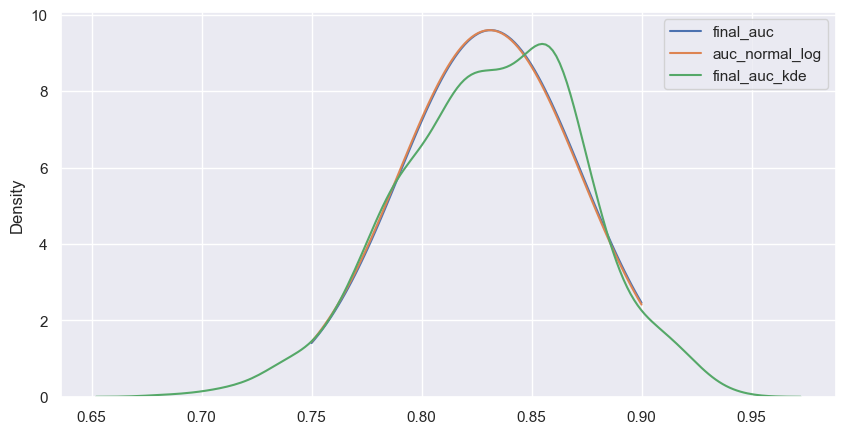

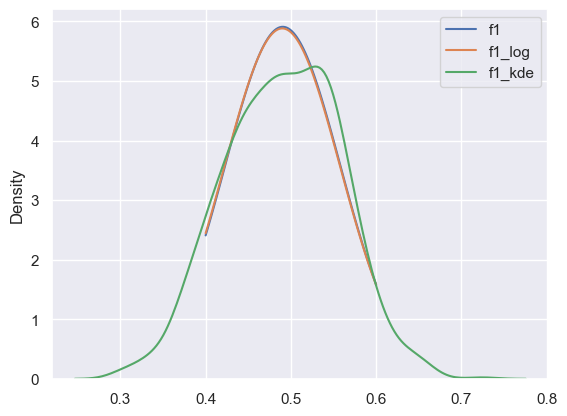

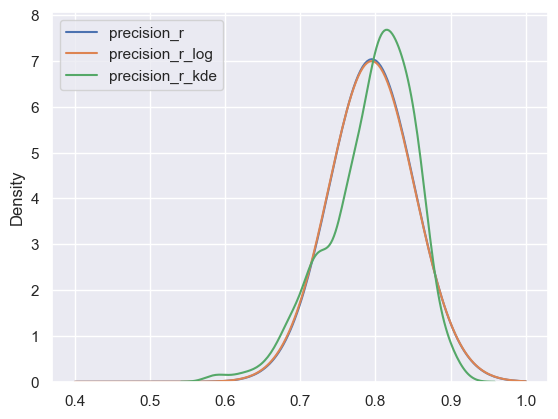

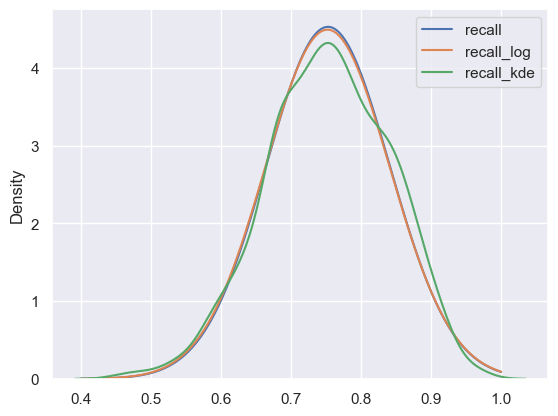

In [7]:
# fit the normal distribution
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
plt.figure(figsize=(10, 5))
final_auc_normal= norm.fit(final_auc)
auc_normal_log_normal=norm.fit(auc_normal_log)
# plot the normal distribution by given mean and std
x = np.linspace(0.75, 0.9, 100)
y = norm.pdf(x, final_auc_normal[0], final_auc_normal[1])
plt.plot(x, y, label='final_auc')
y = norm.pdf(x, auc_normal_log_normal[0], auc_normal_log_normal[1])
plt.plot(x, y, label='auc_normal_log')
sns.kdeplot(final_auc, label='final_auc_kde')
plt.legend()
plt.show()
x = np.linspace(0.4, 0.6, 100)
y = norm.pdf(x, np.mean(f1), np.std(f1))
plt.plot(x, y, label='f1')
y = norm.pdf(x, np.mean(f1_log), np.std(f1_log))
plt.plot(x, y, label='f1_log')
sns.kdeplot(f1, label='f1_kde')
plt.legend()
plt.show()
x = np.linspace(0.4, 1, 200)
y = norm.pdf(x, np.mean(accuracy_score_r), np.std(accuracy_score_r))
plt.plot(x, y, label='precision_r')
y = norm.pdf(x, np.mean(accuracy_score_r_log), np.std(accuracy_score_r_log))
plt.plot(x, y, label='precision_r_log')
sns.kdeplot(accuracy_score_r, label='precision_r_kde')
plt.legend()
plt.show()
x = np.linspace(0.4, 1, 200)
y = norm.pdf(x, np.mean(recall), np.std(recall))
plt.plot(x, y, label='recall')
y = norm.pdf(x, np.mean(recall_log), np.std(recall_log))
plt.plot(x, y, label='recall_log')
sns.kdeplot(recall, label='recall_kde')
plt.legend()
plt.show()


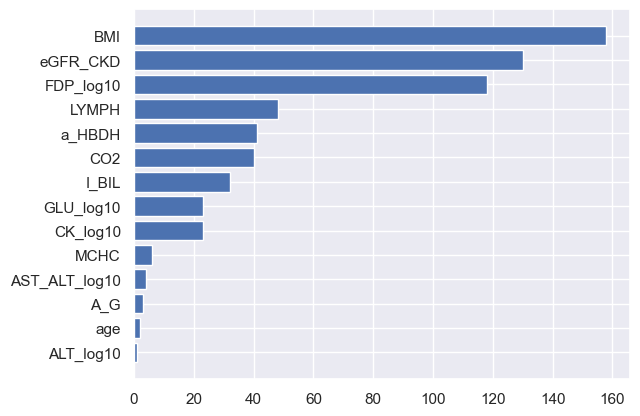

In [8]:
dict = selected_features.T.to_dict('list')
transformed = []
for element in feature_biased:
    transformed.append(dict[element-1])
plot = pd.DataFrame(transformed,columns=['feature'])
plot = plot.value_counts()
plot = plot.sort_values(ascending=True)
plot = pd.DataFrame(plot)
plot = plot.reset_index()
plt.barh(plot['feature'],plot['count'])
plt.savefig('/Users/gengzhi/Desktop/feature_biased.pdf',backend='pdf') 

In [9]:
# get the feature importance
for i in range(0,len(feature_importance)):
    feature_importance[i] = feature_importance[i].flatten()
feature_importance = pd.DataFrame(feature_importance)
feature_importance_mean = feature_importance.mean()
feature_importance_std = feature_importance.std()
feature_importance_mean = pd.DataFrame(feature_importance_mean)
feature_importance_mean = feature_importance_mean.T
feature_importance_std = pd.DataFrame(feature_importance_std)
feature_importance_std = feature_importance_std.T
feature_importance_mean.columns = selected_features['0']
feature_importance_std.columns = selected_features['0']
feature_importance_mean = feature_importance_mean.T
feature_importance_std = feature_importance_std.T
feature_importance_mean = feature_importance_mean.sort_values(by=0,ascending=False)
feature_importance_std = feature_importance_std.loc[feature_importance_mean.index]
feature_importance_mean = feature_importance_mean.reset_index()
feature_importance_std = feature_importance_std.reset_index()

In [10]:
feature_importance_mean.columns = ['index',0]
feature_importance_std.columns = ['index',0]

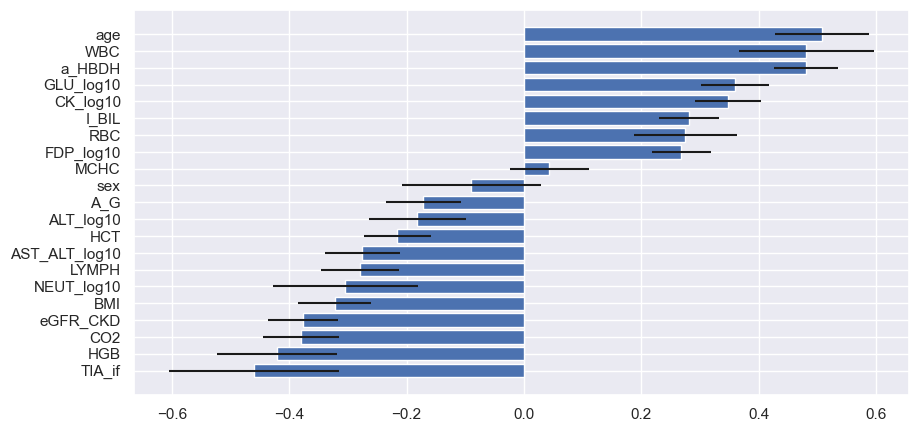

In [11]:
feature_importance_mean = feature_importance_mean.sort_values(by=0,ascending=True)
feature_importance_std = feature_importance_std.loc[feature_importance_mean.index]
feature_importance_mean = feature_importance_mean.reset_index()
feature_importance_std = feature_importance_std.reset_index()
feature_importance_mean.columns = ['index2','index',0]
feature_importance_std.columns = ['index2','index',0]
plt.figure(figsize=(10, 5))
plt.barh(feature_importance_mean['index'],feature_importance_mean[0],xerr=feature_importance_std[0])
plt.savefig('/Users/gengzhi/Desktop/feature_importance_3.pdf',backend='pdf')